In [2]:
from notepad2 import WaterStorage, Heatpump
from pyrecoy.forecasts import Mipf
from datetime import timedelta
from pyrecoy.framework import TimeFramework
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import cufflinks
cufflinks.go_offline()
from numpy.polynomial import Polynomial
import numpy as np

In [4]:
import plotly.express as px
from pyrecoy.colors import *

### Setup & Load data

In [5]:
start = '2018-01-01'
end = '2018-12-31'
end2 = '2019-01-01'

mipf = Mipf(
    start = start,
    end = end, 
    tidy=True, 
    include_nextQ=False,
    folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
).data
price_data = mipf[['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos']]
price_data = price_data.resample('15T').mean()
df = pd.read_csv('smurfit_demand_preprocessed.csv', delimiter=';', decimal=',')
index = pd.date_range(start=start, end=end2, freq='1T', inclusive='left', tz='Europe/Amsterdam')
df.index = index
df = df.resample('15T').mean()

for col in price_data.columns:
    df[col] = price_data[col]

df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-01-01 00:00:00+01:00      64.267667   141.531000       0.0   
2018-01-01 00:15:00+01:00      58.802000   139.423000       0.0   
2018-01-01 00:30:00+01:00      65.176667   139.863667       0.0   
2018-01-01 00:45:00+01:00      65.254000   139.710000       0.0   
2018-01-01 01:00:00+01:00      64.926333   139.559333       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)   DAM    POS  \
2018-01-01 00:00:00+01:00      19.642333   147.779333       0.0  27.2 -57.54   
2018-01-01 00:15:00+01:00      19.613000   148.026000       0.0  27.2  37.02   
2018-01-01 00:30:00+01:00      36.170000   147.527667       0.0  27.2  33.10   
2018-01-01 00:45:00+01:00      35.220000   147.763000       0.0  27.2  33.10   
2018-01-01 01:00:00+01:00      18.850000   148.306000       0.0  27.3  33.09   

                             NEG    ForeNeg    ForePos  
2018-01-01 00:00:00+01:00  58.62  36.246667 -12.529333  
2018-01-01 00:15:00+01:00  37.02  29.646667  21.791333  
2018-01-01 00:30:00+01:00  33.10  32.346667  31.408000  
2018-01-01 00:45:00+01:00  33.10  37.126000  33.512000  
2018-01-01 01:00:00+01:00  33.09  34.805333  33.970000

### Create asset

In [6]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    capacity_per_volume = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
)
waterstorage.set_freq('15T')
waterstorage.storagelevel

5

In [7]:
def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=0,
    cop_curve=cop_curve
)

In [8]:
e, h = heatpump.set_heat_output(10, 140, 90)

cop = -h/e

cop_check = cop_curve(140, 90)(0)

assert cop == cop_check

### Inputs

In [9]:
Tref = 0
Cp = 4190  #J/kgK
MWtoJs = 1000_000
Tstorage = 95
storage_output_power = 10
# This might be 25 MW according to literature

In [10]:
def power_to_mass_flow(power_MW, Tsink, Tref, Cp):
    return power_MW * MWtoJs /(Cp*(Tsink - Tref))

def energy_to_storage(hp_heat_output_MW, process_demand_MW):
    return hp_heat_output_MW - process_demand_MW  #MW

def Tsource_calculation(Tstorage, discharge_power, Tsource, process_mass_flow):   
    discharge_mass_flow = power_to_mass_flow(discharge_power, Tstorage, Tref, Cp)
    
    combined_mass_flow = (discharge_mass_flow + process_mass_flow)
    if combined_mass_flow == 0:
        return 0
    else: 
        return (Tstorage * discharge_mass_flow + Tsource * process_mass_flow) / combined_mass_flow

In [11]:
df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-01-01 00:00:00+01:00      64.267667   141.531000       0.0   
2018-01-01 00:15:00+01:00      58.802000   139.423000       0.0   
2018-01-01 00:30:00+01:00      65.176667   139.863667       0.0   
2018-01-01 00:45:00+01:00      65.254000   139.710000       0.0   
2018-01-01 01:00:00+01:00      64.926333   139.559333       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)   DAM    POS  \
2018-01-01 00:00:00+01:00      19.642333   147.779333       0.0  27.2 -57.54   
2018-01-01 00:15:00+01:00      19.613000   148.026000       0.0  27.2  37.02   
2018-01-01 00:30:00+01:00      36.170000   147.527667       0.0  27.2  33.10   
2018-01-01 00:45:00+01:00      35.220000   147.763000       0.0  27.2  33.10   
2018-01-01 01:00:00+01:00      18.850000   148.306000       0.0  27.3  33.09   

                             NEG    ForeNeg    ForePos  
2018-01-01 00:00:00+01:00  58.62  36.246667 -12.529333  
2018-01-01 00:15:00+01:00  37.02  29.646667  21.791333  
2018-01-01 00:30:00+01:00  33.10  32.346667  31.408000  
2018-01-01 00:45:00+01:00  33.10  37.126000  33.512000  
2018-01-01 01:00:00+01:00  33.09  34.805333  33.970000

In [12]:
# First base case simulation
# Then opt case simulation
# Inputs are Demand, Tsource, Tsink
# Constraint: Storage level
# Functionality: 

# - Set new storage level
# - Save COP, new Tsource

dam_prices = df['DAM'].to_list()
pos_prices = df['POS'].to_list()
neg_prices = df['NEG'].to_list()
tsinks = df['Tsink (VDG)'].to_list()
tsources = df['Tsource (VDG)'].to_list()
demands = df['MW (VDG)'].to_list()
qhs = len(df)

bl_hp_th_loads = [None] * qhs
bl_hp_e_loads = [None] * qhs
opt_hp_th_loads = [None] * qhs
opt_hp_e_loads = [None] * qhs
storage_levels = [None] * qhs
to_storage_list = [None] * qhs
from_storage_list = [None] * qhs
new_tsources = df['Tsource (VDG)'].to_list()

In [13]:
waterstorage.set_storagelevel(waterstorage.min_storagelevel)

for q in range(qhs):
    demand = demands[q]
    tsource = tsources[q]
    tsink = tsinks[q]
    
    from_storage_MW = 0
    to_storage_MW = 0
    
    # baseline
    bl_hp_e_loads[q], bl_hp_th_loads[q] = heatpump.set_heat_output(
        heat_output = demand,
        Tsink = tsink,
        Tsource = tsource
    )
    
    if neg_prices[q] < dam_prices[q] - 10:
        # overproduce/charge
        desired_hp_load = min(demand + waterstorage.charging_power_limit, heatpump.max_th_power)
        e_load, th_load = heatpump.set_heat_output(desired_hp_load, tsink, tsource)
        to_storage_MW = th_load - demand
        to_storage_MW = waterstorage.charge(to_storage_MW)
    elif pos_prices[q] > dam_prices[q] + 10:
        # take from storage/discharge
        from_storage_MW = min(storage_output_power, waterstorage.discharging_power_limit)
        from_process_massflow = power_to_mass_flow(demand, tsink, Tref, Cp)
        tsource = Tsource_calculation(Tstorage, from_storage_MW, tsource, from_process_massflow)
        e_load, th_load = heatpump.set_heat_output(demand, tsink, tsource)
        from_storage_MW = waterstorage.discharge(from_storage_MW)
    else:
        e_load = bl_hp_e_loads[q]
        th_load = bl_hp_th_loads[q]
    
    opt_hp_e_loads[q] = e_load
    opt_hp_th_loads[q] = th_load
    storage_levels[q] = waterstorage.storagelevel
    new_tsources[q] = tsource
    to_storage_list[q] = to_storage_MW
    from_storage_list[q] = from_storage_MW
    
df['bl_e_load_MW'] = bl_hp_e_loads
df['bl_th_load_MW'] = bl_hp_th_loads
df['bl_cop'] = df['bl_th_load_MW'] / -df['bl_e_load_MW']
df['opt_e_load_MW'] = opt_hp_e_loads
df['opt_th_load_MW'] = opt_hp_th_loads
df['storage_level_MWh'] = storage_levels
df['to_storage_MW'] = to_storage_list
df['from_storage_MW'] = from_storage_list

df['opt_Tsource'] = new_tsources
df['opt_cop'] = df['opt_th_load_MW'] / -df['opt_e_load_MW']

df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-01-01 00:00:00+01:00      64.267667   141.531000       0.0   
2018-01-01 00:15:00+01:00      58.802000   139.423000       0.0   
2018-01-01 00:30:00+01:00      65.176667   139.863667       0.0   
2018-01-01 00:45:00+01:00      65.254000   139.710000       0.0   
2018-01-01 01:00:00+01:00      64.926333   139.559333       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)   DAM    POS  \
2018-01-01 00:00:00+01:00      19.642333   147.779333       0.0  27.2 -57.54   
2018-01-01 00:15:00+01:00      19.613000   148.026000       0.0  27.2  37.02   
2018-01-01 00:30:00+01:00      36.170000   147.527667       0.0  27.2  33.10   
2018-01-01 00:45:00+01:00      35.220000   147.763000       0.0  27.2  33.10   
2018-01-01 01:00:00+01:00      18.850000   148.306000       0.0  27.3  33.09   

                             NEG    ForeNeg  ...  bl_e_load_MW  bl_th_load_MW  \
2018-01-01 00:00:00+01:00  58.62  36.246667  ...          -0.0            0.0   
2018-01-01 00:15:00+01:00  37.02  29.646667  ...          -0.0            0.0   
2018-01-01 00:30:00+01:00  33.10  32.346667  ...          -0.0            0.0   
2018-01-01 00:45:00+01:00  33.10  37.126000  ...          -0.0            0.0   
2018-01-01 01:00:00+01:00  33.09  34.805333  ...          -0.0            0.0   

                           bl_cop  opt_e_load_MW  opt_th_load_MW  \
2018-01-01 00:00:00+01:00     NaN           -0.0             0.0   
2018-01-01 00:15:00+01:00     NaN           -0.0             0.0   
2018-01-01 00:30:00+01:00     NaN           -0.0             0.0   
2018-01-01 00:45:00+01:00     NaN           -0.0             0.0   
2018-01-01 01:00:00+01:00     NaN           -0.0             0.0   

                           storage_level_MWh  to_storage_MW  from_storage_MW  \
2018-01-01 00:00:00+01:00                5.0            0.0              0.0   
2018-01-01 00:15:00+01:00                5.0            0.0              0.0   
2018-01-01 00:30:00+01:00                5.0            0.0              0.0   
2018-01-01 00:45:00+01:00                5.0            0.0              0.0   
2018-01-01 01:00:00+01:00                5.0            0.0              0.0   

                           opt_Tsource  opt_cop  
2018-01-01 00:00:00+01:00    64.267667      NaN  
2018-01-01 00:15:00+01:00    58.802000      NaN  
2018-01-01 00:30:00+01:00    65.176667      NaN  
2018-01-01 00:45:00+01:00    65.254000      NaN  
2018-01-01 01:00:00+01:00    64.926333      NaN  

[5 rows x 21 columns]

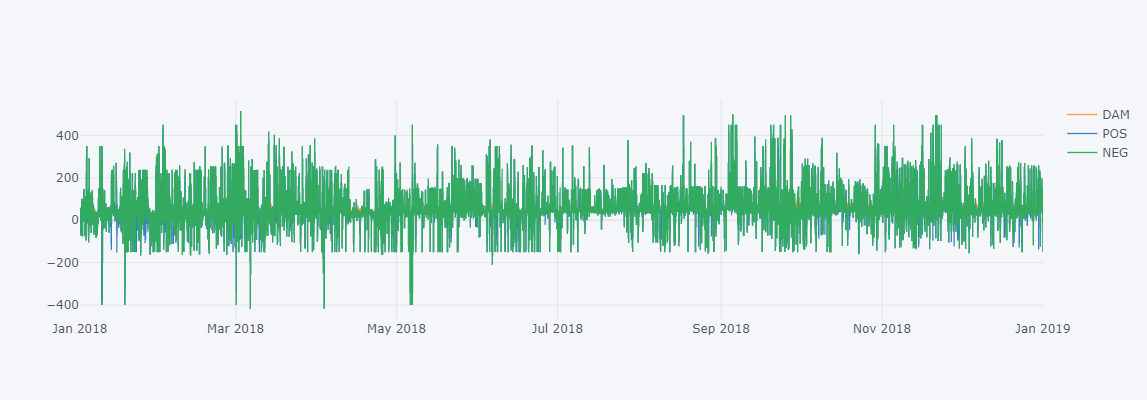

In [14]:
df[['DAM', 'POS', 'NEG']].iplot(dimensions=(1100, 400))

In [15]:
df['bl_cop', 'opt_cop'].describe()

KeyError: ('bl_cop', 'opt_cop')

In [ ]:
df[['POS', 'NEG', 'MW (VDG)', 'opt_th_load_MW', 'storage_level_MWh', 'opt_cop', 'to_storage_MW', 'from_storage_MW']].iplot(subplots=True, shape=(8, 1), dimensions=(1200, 1000))

In [ ]:
df.head()

In [ ]:
df['bl_e_load_MW'].describe()

In [ ]:
for col in df.columns:
    if col.endswith('MW'):
        df[col + 'h'] = df[col] / 4
        
df['nomination_MWh'] = df['bl_e_load_MWh']
df['imbalance_MWh'] = df['opt_e_load_MWh'] - df['nomination_MWh']


In [ ]:
ex = pd.DataFrame({
    'A': [1,2,3],
    'B': [4,5,6]
})
ex.index = ['i1', 'i2', 'i3']
ex

In [ ]:
ex.loc['i2', 'B']

In [ ]:
ex['B'] 

In [ ]:
ex[ex['A'] > 2]

In [ ]:
def calc_costs(df, nomination_col, realisation_col):
    dayahead_costs = df[nomination_col] * df['DAM'] 

    imbalance = df[realisation_col] - df[nomination_col]
    imbalance_costs = pd.Series(0, index=df.index)
    is_pos = imbalance > 0
    imbalance_costs[is_pos] = imbalance[is_pos] * df['POS'] 

    is_neg = imbalance < 0
    imbalance_costs[is_neg] = imbalance[is_neg] * df['NEG']

    return dayahead_costs  + imbalance_costs

df['bl_costs'] = calc_costs(df, 'nomination_MWh', 'nomination_MWh')
df['opt_costs'] = calc_costs(df, 'nomination_MWh', 'opt_e_load_MWh')
df[['bl_costs', 'opt_costs']].sum() / df['bl_costs'].sum()

rea

In [ ]:
df[['storage_level_MWh', 'opt_cop', 'to_storage_MW', 'from_storage_MW']].iplot(subplots=True, shape=(4, 1), dimensions=(1000, 800))

In [ ]:
df[['POS', 'NEG', 'MW (VDG)', 'opt_th_load_MW']].iplot(subplots=True, shape=(4, 1), dimensions=(1000, 800))

In [ ]:
#per month
# -+10, 2.3%
# -+20, 3.1% saving
# -+30, 3.7% saving
# -+40, 4.1% saving
# -+50, 4.5% saving
# -+60, 4.0% saving
# -+70, 3.5% saving
# -+80, 3.1% saving
# -+90, 2.7% saving
# -+100, 2.3% saving

In [ ]:
#per year
# +-10, 1.9%
#  +-20, 3.5%
#  +-30, 4.5%
#  +-40, 5%
#  +-50, 5.1%
#  +-60, 4.9%
#  +-70, 4.7%
#  +-80, 4.5%
#  +-90, 4.3%
#  +-100, 4.1%